# 1.31d: Velocity Autocorrelation and Phase Transitions

**Hypothesis:** Velocity autocorrelation ρ(t) reveals phase transitions in dead token dynamics.

## Velocity Autocorrelation

For each token, compute the correlation between consecutive velocity vectors:

$$\rho(t) = \frac{\Delta W'(t) \cdot \Delta W'(t+1)}{|\Delta W'(t)| \cdot |\Delta W'(t+1)|}$$

where ΔW′(t) is the displacement vector at timestep t (in lattice coordinates).

**Expected behavior:**

- **Hot phase (Classical Gas):** Large coherent gradient steps → ρ ≈ +1 (strongly correlated)
- **Cooling:** Gradient weakens, correlation drops
- **Cold phase (Fimbulwinter):** Single-cell random hops in 64D → ρ ≈ 0 (statistically orthogonal)

The transition from ρ ≈ 1 to ρ ≈ 0 should mark the onset of quantized thermal motion.

## Parameters

In [7]:
DELTA_W_PRIME_PATH = "../tensors/Thimble/1.31c_delta_W_prime_dead.safetensors"
DPI = 200
ALPHA_INDIVIDUAL = 0.005  # Transparency for individual token traces

## Imports

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [9]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load ΔW′ (Lattice Coordinate Displacements)

In [10]:
print(f"Loading ΔW′ from {DELTA_W_PRIME_PATH}...\n")

data = load_file(DELTA_W_PRIME_PATH)
delta_W_prime = data['delta_W_prime'].to(device)  # (6000, 3699, 64)

n_timesteps, n_tokens, hidden_dim = delta_W_prime.shape

print(f"✓ Loaded ΔW′")
print(f"  Shape: {delta_W_prime.shape}")
print(f"  Timesteps: {n_timesteps}")
print(f"  Tokens: {n_tokens}")
print(f"  Hidden dim: {hidden_dim}")
print(f"  Memory: {delta_W_prime.element_size() * delta_W_prime.nelement() / 1e9:.2f} GB")

Loading ΔW′ from ../tensors/Thimble/1.31c_delta_W_prime_dead.safetensors...

✓ Loaded ΔW′
  Shape: torch.Size([6000, 3699, 64])
  Timesteps: 6000
  Tokens: 3699
  Hidden dim: 64
  Memory: 5.68 GB


## Compute Velocity Autocorrelation ρ(t)

For each token at each timestep, compute:

$$\rho(t) = \frac{v(t) \cdot v(t+1)}{|v(t)| \cdot |v(t+1)|}$$

where v(t) = ΔW′(t) is the velocity vector.

In [11]:
print("Computing velocity autocorrelation...\n")

# Velocity vectors: v(t) = ΔW′(t)
v_t = delta_W_prime[:-1]    # (5999, 3699, 64)
v_t1 = delta_W_prime[1:]    # (5999, 3699, 64)

# Dot product: v(t) · v(t+1)
dot_product = (v_t * v_t1).sum(dim=2)  # (5999, 3699)

# Magnitudes
mag_t = torch.norm(v_t, dim=2)    # (5999, 3699)
mag_t1 = torch.norm(v_t1, dim=2)  # (5999, 3699)

# Correlation coefficient: ρ(t) = dot / (|v_t| * |v_t1|)
# Add epsilon to avoid division by zero when both velocities are zero
rho = dot_product / (mag_t * mag_t1 + 1e-30)  # (5999, 3699)

print(f"✓ Velocity autocorrelation computed")
print(f"  Shape: {rho.shape}")
print(f"  Range: [{rho.min().item():.3f}, {rho.max().item():.3f}]")
print(f"  Mean: {rho.mean().item():.3f}")

Computing velocity autocorrelation...

✓ Velocity autocorrelation computed
  Shape: torch.Size([5999, 3699])
  Range: [-0.820, 1.000]
  Mean: 0.108


## Handle Special Cases

When both v(t) and v(t+1) are zero (token is frozen), ρ is undefined. Let's identify these cases and handle them separately.

In [12]:
# Identify cases where both velocities are zero
both_zero = (mag_t == 0) & (mag_t1 == 0)
n_both_zero = both_zero.sum().item()

# Identify cases where only one is zero (also problematic)
one_zero = ((mag_t == 0) & (mag_t1 != 0)) | ((mag_t != 0) & (mag_t1 == 0))
n_one_zero = one_zero.sum().item()

# Valid correlations (both velocities nonzero)
valid = (mag_t > 0) & (mag_t1 > 0)
n_valid = valid.sum().item()

print(f"Special cases:")
print(f"  Both v(t) and v(t+1) zero: {n_both_zero:,}  (frozen)")
print(f"  One velocity zero: {n_one_zero:,}")
print(f"  Valid correlations: {n_valid:,}")
print()

# Set invalid correlations to NaN for cleaner statistics
rho_clean = rho.clone()
rho_clean[~valid] = float('nan')

# Move to CPU for min/max (numpy handles NaN)
rho_clean_cpu = rho_clean.cpu().numpy()

print(f"After cleaning:")
print(f"  Valid range: [{np.nanmin(rho_clean_cpu):.3f}, {np.nanmax(rho_clean_cpu):.3f}]")
print(f"  Valid mean: {np.nanmean(rho_clean_cpu):.3f}")

Special cases:
  Both v(t) and v(t+1) zero: 19,345,012  (frozen)
  One velocity zero: 343,293
  Valid correlations: 2,501,997

After cleaning:
  Valid range: [-0.820, 1.000]
  Valid mean: 0.955


## Compute Statistics Over Time

In [13]:
# Move to CPU for statistics
rho_cpu = rho_clean.cpu().numpy()

# Compute median, mean, and percentiles at each timestep
# Use nanmedian/nanmean to ignore NaN values
median_rho = np.nanmedian(rho_cpu, axis=1)  # (5999,)
mean_rho = np.nanmean(rho_cpu, axis=1)      # (5999,)
p25_rho = np.nanpercentile(rho_cpu, 25, axis=1)
p75_rho = np.nanpercentile(rho_cpu, 75, axis=1)

# Timesteps (note: we have 5999 correlation values for 6000 velocity vectors)
timesteps = np.arange(1, 6000)

print(f"Summary statistics computed over {len(timesteps)} timesteps.")

/Users/jefferyharrell/Projects/Azimuth_II/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1216: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,
/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_27086/2878740938.py:7: RuntimeWarning: Mean of empty slice
  mean_rho = np.nanmean(rho_cpu, axis=1)      # (5999,)
/Users/jefferyharrell/Projects/Azimuth_II/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


Summary statistics computed over 5999 timesteps.


## Plot: All Token Traces + Median

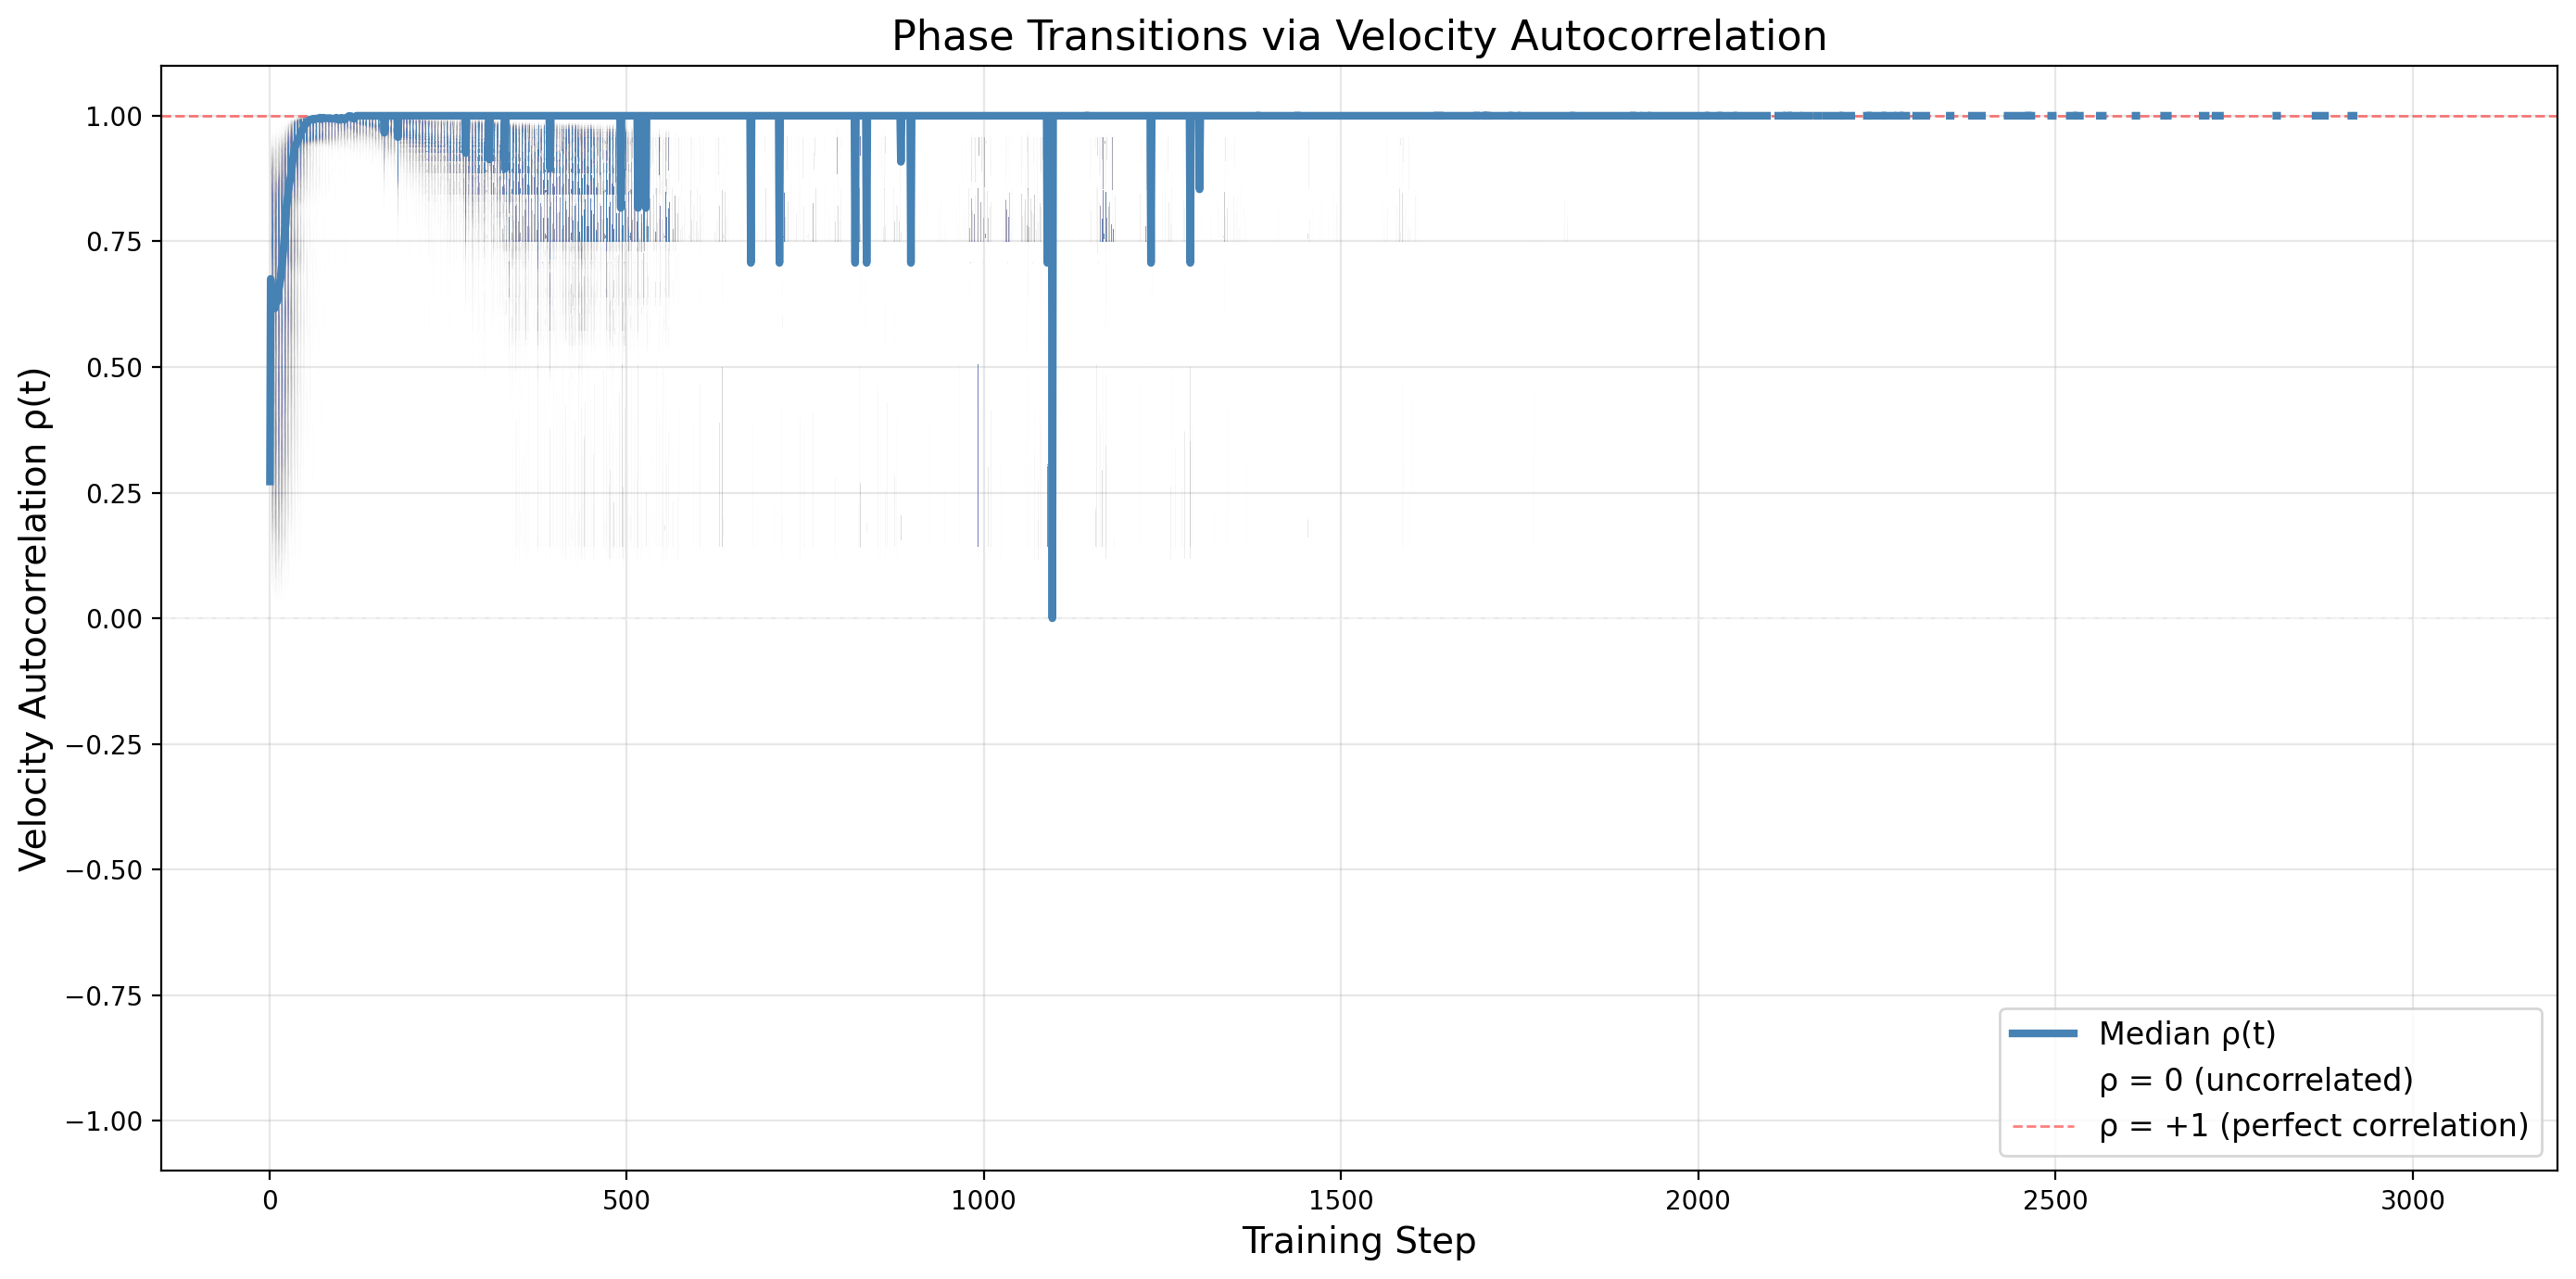

In [29]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=DPI)

# Plot all individual token traces (very transparent)
for i in range(n_tokens):
    ax.plot(timesteps, rho_cpu[:, i], 
            color='steelblue', alpha=ALPHA_INDIVIDUAL, linewidth=0.1)

# Plot median on top (prominent)
ax.plot(timesteps, median_rho, color='steelblue', linewidth=3, label='Median ρ(t)', zorder=10)

# Reference lines
ax.axhline(0, color='white', linestyle='--', linewidth=1, alpha=0.5, label='ρ = 0 (uncorrelated)')
ax.axhline(1, color='red', linestyle='--', linewidth=1, alpha=0.5, label='ρ = +1 (perfect correlation)')

ax.set_xlabel('Training Step', fontsize=14)
ax.set_ylabel('Velocity Autocorrelation ρ(t)', fontsize=14)
ax.set_title('Phase Transitions via Velocity Autocorrelation', fontsize=16)
ax.set_ylim(-1.1, 1.1)
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Plot: Median with Interquartile Range

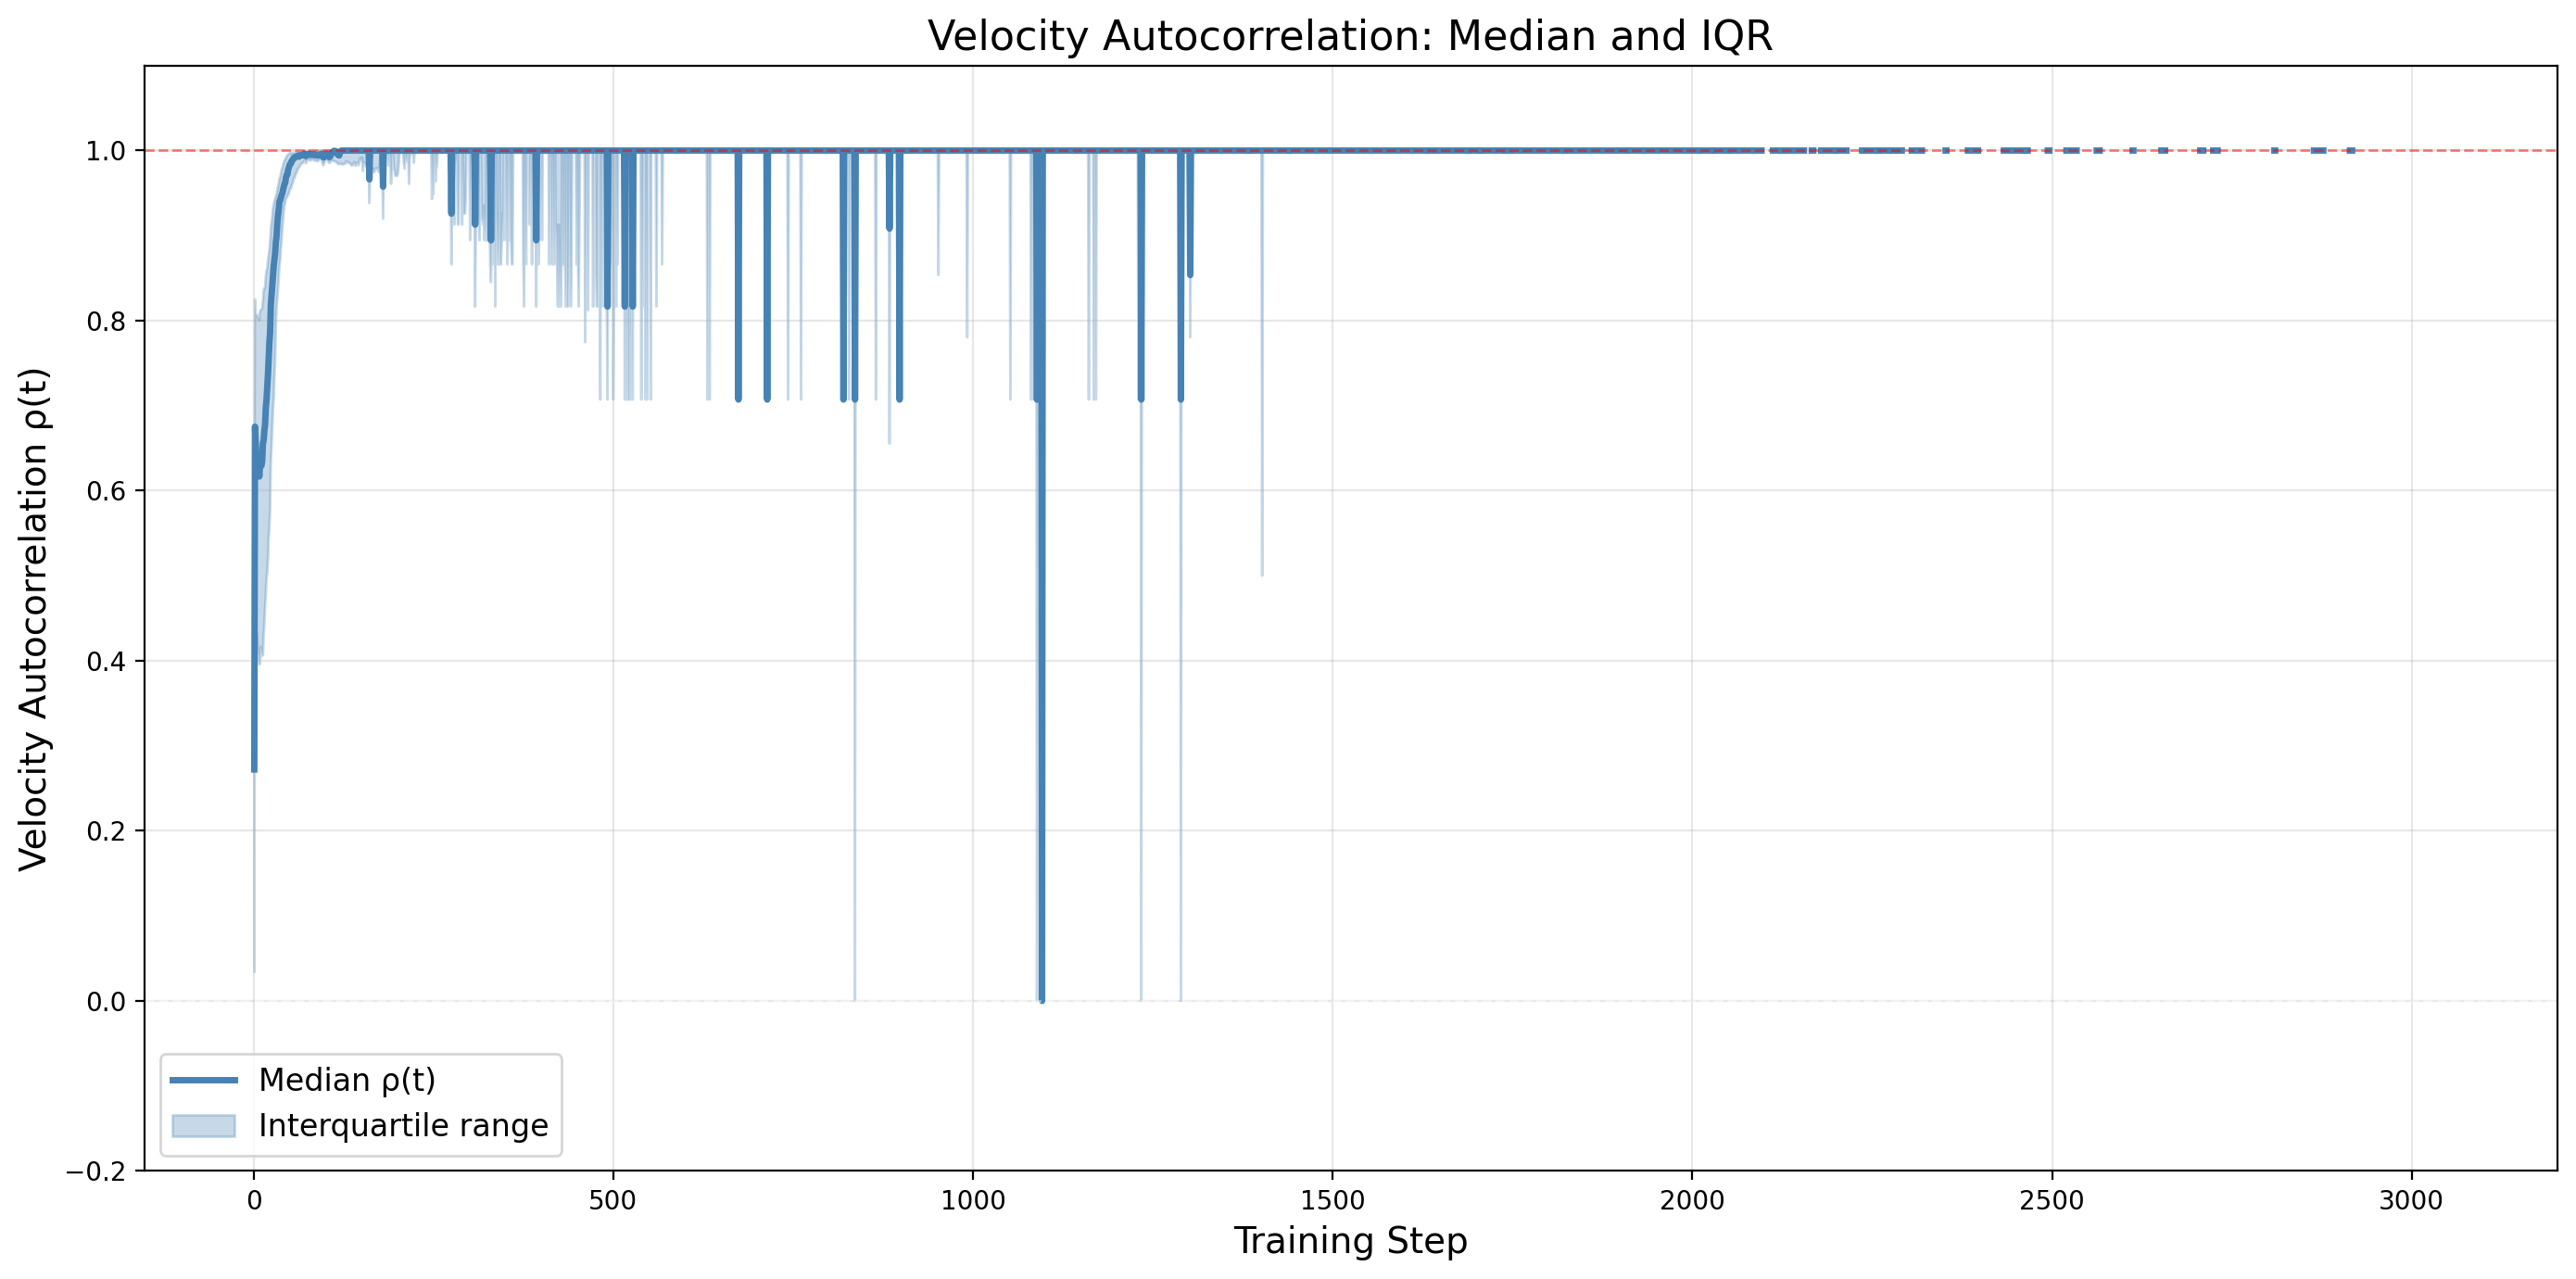

In [38]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=DPI)

# Plot median
ax.plot(timesteps, median_rho, color='steelblue', linewidth=2.5, label='Median ρ(t)')

# Plot interquartile range (25th to 75th percentile)
ax.fill_between(timesteps, p25_rho, p75_rho, 
                color='steelblue', alpha=0.3, label='Interquartile range')

# Reference lines
ax.axhline(0, color='white', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(1, color='red', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('Training Step', fontsize=14)
ax.set_ylabel('Velocity Autocorrelation ρ(t)', fontsize=14)
ax.set_title('Velocity Autocorrelation: Median and IQR', fontsize=16)
ax.set_ylim(-0.2, 1.1)
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Early Timesteps: Zoomed View

Let's zoom in on the first 500 steps to see the initial drop clearly.

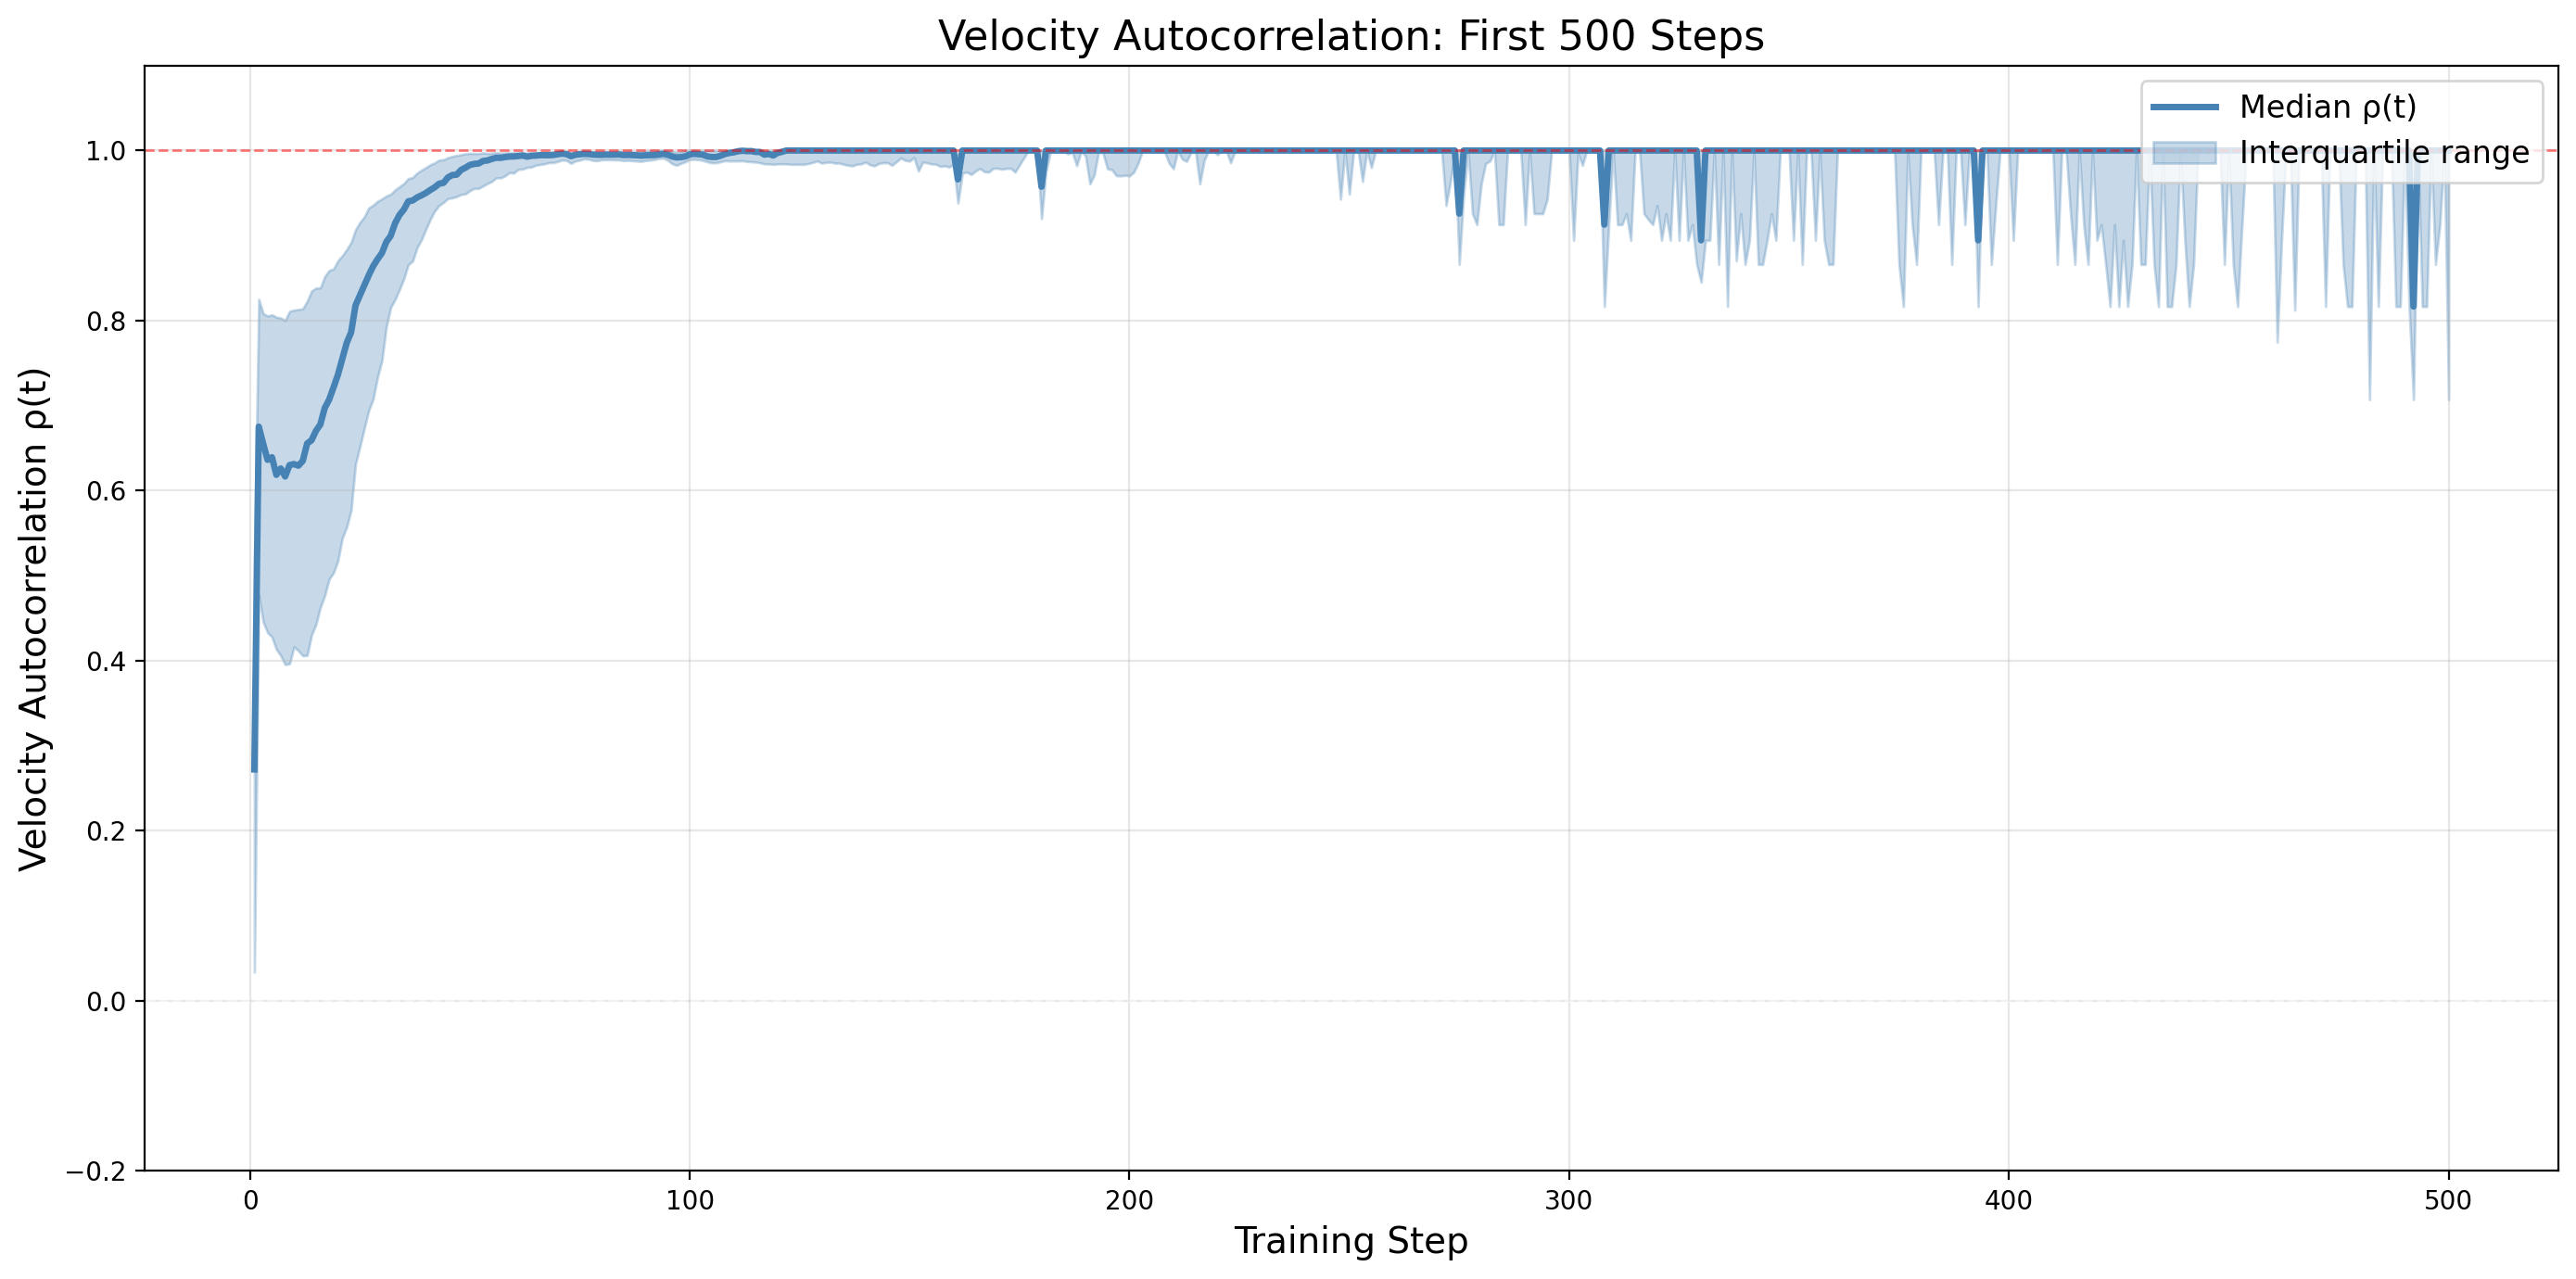

In [45]:
ZOOM_STEPS = 500

fig, ax = plt.subplots(figsize=(14, 7), dpi=DPI)

# Plot median (zoomed)
ax.plot(timesteps[:ZOOM_STEPS], median_rho[:ZOOM_STEPS], 
        color='steelblue', linewidth=2.5, label='Median ρ(t)')

# Plot IQR
ax.fill_between(timesteps[:ZOOM_STEPS], 
                p25_rho[:ZOOM_STEPS], 
                p75_rho[:ZOOM_STEPS], 
                color='steelblue', alpha=0.3, label='Interquartile range')

# Reference lines
ax.axhline(0, color='white', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(1, color='red', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('Training Step', fontsize=14)
ax.set_ylabel('Velocity Autocorrelation ρ(t)', fontsize=14)
ax.set_title(f'Velocity Autocorrelation: First {ZOOM_STEPS} Steps', fontsize=16)
ax.set_ylim(-0.2, 1.1)
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Identify Phase Transition Point

When does ρ drop below a threshold (e.g., ρ < 0.1) indicating transition to uncorrelated motion?

In [46]:
THRESHOLD = 0.1

# Find first timestep where median ρ < threshold
below_threshold = np.where(median_rho < THRESHOLD)[0]

if len(below_threshold) > 0:
    transition_step = timesteps[below_threshold[0]]
    transition_rho = median_rho[below_threshold[0]]
    
    print(f"Phase transition detected:")
    print(f"  First step where median ρ < {THRESHOLD}: t = {transition_step}")
    print(f"  Median ρ at transition: {transition_rho:.4f}")
    print()
    print(f"Interpretation:")
    print(f"  Before t={transition_step}: Coherent gradient descent (ρ > {THRESHOLD})")
    print(f"  After t={transition_step}: Quantized thermal motion (ρ ≈ 0)")
else:
    print(f"No transition found: median ρ remains > {THRESHOLD} throughout training.")

Phase transition detected:
  First step where median ρ < 0.1: t = 1096
  Median ρ at transition: 0.0000

Interpretation:
  Before t=1096: Coherent gradient descent (ρ > 0.1)
  After t=1096: Quantized thermal motion (ρ ≈ 0)


## Summary Statistics

In [47]:
print("=" * 80)
print("VELOCITY AUTOCORRELATION SUMMARY")
print("=" * 80)
print()

# Early, middle, late statistics
early_median = np.nanmedian(median_rho[:100])
middle_median = np.nanmedian(median_rho[2500:2600])
late_median = np.nanmedian(median_rho[-100:])

print(f"Median ρ by phase:")
print(f"  Early (t=1-100):      {early_median:.4f}")
print(f"  Middle (t=2500-2600): {middle_median:.4f}")
print(f"  Late (t=5900-5999):   {late_median:.4f}")
print()

# Fraction of time spent in each regime
high_corr = (median_rho > 0.5).sum()
low_corr = (median_rho < 0.1).sum()

print(f"Time spent in each regime:")
print(f"  High correlation (ρ > 0.5):  {high_corr} steps  ({high_corr/len(median_rho):.1%})")
print(f"  Low correlation (ρ < 0.1):   {low_corr} steps  ({low_corr/len(median_rho):.1%})")

print()
print("=" * 80)

VELOCITY AUTOCORRELATION SUMMARY

Median ρ by phase:
  Early (t=1-100):      0.9836
  Middle (t=2500-2600): 1.0000
  Late (t=5900-5999):   nan

Time spent in each regime:
  High correlation (ρ > 0.5):  2265 steps  (37.8%)
  Low correlation (ρ < 0.1):   1 steps  (0.0%)



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_27086/1038658112.py:9: RuntimeWarning: All-NaN slice encountered
  late_median = np.nanmedian(median_rho[-100:])
